## HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Summer 2022`__

HW4 is composed of two sections (see module 6 for access to the HW4 sections):

* A timed quiz (20 questions) with all questions available in Canvas only. You will need a Spark cluster to complete the questions. You will get three attempts to complete this quiz and you will get some feedback after each attempt. 
* A regular assignment in the form of a Jupyter notebook and Canvas quiz with no immediate feedback upon submission. 
NOTE: both parts will be graded and will contribute to your overall grade for the semester.

This notebook and Canvas quiz forms part 2 of 2 for HW4.

In the first three HW assignments, you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning algorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this assignment, you will learn linear models using different loss functions: OLS, RidgeMSE, LassoMSE, BXE, CXE, RidgeBXE, LASSOBXE, etc.. As in previous assignments, you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:

* ... __define__ the loss functions for linear regression and linear classifier models OLS, RidgeMSE, LassoMSE, BXE, CXE, RidgeBXE, LASSOBXE, etc.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [latest (3.2.0) Spark Documentation - RDD programming guide](https://spark.apache.org/docs/3.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

## Start Spark and the Spark UI

In [3]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import os

try:
    spark
except NameError:
    print('starting Spark')
    app_name = 'Lab6_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

ZONE = os.getenv("ZONE") #new as of June 17, 2022 4:45PM PST; restart cluster to see thus env variable
spark_UI_info = f'''
To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone {ZONE} --ssh-flag "-L 8080:localhost:4040" '''

print(spark_UI_info)

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-35ed19f2-f4a9-4bdb-8aac-094018c5c055;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.1.3 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 331ms :: artifacts dl 8ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.1-s_2.12 from spark-packages in [default]
	org.apache.spark#spark-avro_2.12;3.1.3 from central in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	org.spark-project.spark#unused;1.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            mo


To start the SPARK UI

Copy the following command  to cloud shell and run as shown in the screenshot below. 
And click on the PREVIEW ON PORT 8080 menu option .
Run the following command to establish the SSH Tunnel:

gcloud compute ssh w261-m --zone us-central1-b --ssh-flag "-L 8080:localhost:4040" 



<img src='https://www.dropbox.com/s/tlb4uiakj2bx7qg/Three_steps_launch_SparkUI.png?raw=true' style='width:100%'>

In [4]:
spark

## Set up global variables for cloud buckets (both Data, Staging) and for Zone 

In [5]:
# Access your personal data bucket and see whats there
# (RUN THIS CELL AS IS)
import os
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1] # our private storage bucket location
HW4_FOLDER = f"{DATA_BUCKET}/main/Assignments/HW4/"
print(f"Personal Data bucket:  {DATA_BUCKET}")
!gsutil ls -lh  {HW4_FOLDER}  #lets have a look the HW folder on our private storage bucket
print(f"STAGING_BUCKET location: {os.getenv('STAGING_BUCKET')}")
!gsutil ls -lh {os.getenv("STAGING_BUCKET")}notebooks/jupyter

Personal Data bucket:  gs://hw_data_bucket
 82.23 KiB  2022-07-02T16:37:20Z  gs://hw_data_bucket/main/Assignments/HW4/reds.csv
258.23 KiB  2022-07-02T16:37:22Z  gs://hw_data_bucket/main/Assignments/HW4/whites.csv
                                 gs://hw_data_bucket/main/Assignments/HW4/docker/
TOTAL: 2 objects, 348625 bytes (340.45 KiB)
STAGING_BUCKET location: gs://dataproc-staging-us-central1-275377091776-oiu4zcrv/
       0 B  2022-05-07T20:15:35Z  gs://dataproc-staging-us-central1-275377091776-oiu4zcrv/notebooks/jupyter/
                                 gs://dataproc-staging-us-central1-275377091776-oiu4zcrv/notebooks/jupyter/snapshots/
                                 gs://dataproc-staging-us-central1-275377091776-oiu4zcrv/notebooks/jupyter/student-workspace/
                                 gs://dataproc-staging-us-central1-275377091776-oiu4zcrv/notebooks/jupyter/ucb-w261-master/
TOTAL: 1 objects, 0 bytes (0 B)


# Question 1: Optimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behind why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) Multiple Dropdown on Canvas:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) Short Answer:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) Matching on Canvas:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) Short Answer:__ In the context of OLS, what do we mean by a 'closed-form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Type your answer here!  

> __d)__ Type your answer here!

# Load data and do EDA

## About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [6]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

mkdir: cannot create directory ‘data’: File exists


In [7]:
!ls -l data

total 544
-rw-r--r-- 1 root root   2500 Jul  2 16:43 OLSloss.csv
-rw-r--r-- 1 root root  16250 Jul  2 16:43 OLSmodels.csv
-rw-r--r-- 1 root root 174313 Jul  2 16:30 alice.txt
-rw-r--r-- 1 root root    119 Jul  2 16:30 chineseTest.txt
-rw-r--r-- 1 root root    107 Jul  2 16:30 chineseTrain.txt
-rw-r--r-- 1 root root  84199 Oct 16  2009 reds.csv
-rw-r--r-- 1 root root 264426 Oct 16  2009 whites.csv


In [8]:
!head data/reds.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [9]:
# put data on personal bucket - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}reds.csv'
!cat data/reds.csv | gsutil cp - {data_loc}   
data_loc = f'{HW4_FOLDER}whites.csv'
!cat data/whites.csv | gsutil cp - {data_loc}                                    

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [10]:
!gsutil ls -l {HW4_FOLDER}

     84199  2022-07-02T17:04:27Z  gs://hw_data_bucket/main/Assignments/HW4/reds.csv
    264426  2022-07-02T17:04:30Z  gs://hw_data_bucket/main/Assignments/HW4/whites.csv
                                 gs://hw_data_bucket/main/Assignments/HW4/docker/
TOTAL: 2 objects, 348625 bytes (340.45 KiB)


In [11]:
# load data - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}whites.csv'
!gsutil cat  -h  {data_loc}|head

==> gs://hw_data_bucket/main/Assignments/HW4/whites.csv <==
"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6
8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6
7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6
7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6
8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6
6.2;0.32;0.16;7;0.045;30;136;0.9949;3.18;0.47;9.6;6
7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6


In [12]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [13]:
# load the raw data into an RDD - RUN THIS CELL AS IS
data_loc = f'{HW4_FOLDER}reds.csv'
redsRDD = sc.textFile(data_loc)\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
data_loc = f'{HW4_FOLDER}whites.csv'
whitesRDD = sc.textFile(data_loc)\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine
redsRDD.count(), whitesRDD.count()

(1599, 4898)

In [14]:
redsRDD.take(5)

['1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5',
 '1;7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5',
 '1;7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5',
 '1;11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6',
 '1;7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5']

In [15]:
whitesRDD.take(5)

['0;7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6',
 '0;6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9.5;6',
 '0;8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;10.1;6',
 '0;7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6',
 '0;7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4;9.9;6']

In [16]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [17]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [18]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

## Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:

* __a) Multiple Answers on Canvas:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Which features appear normally distributed?

* __b) Multiple Choice Answer on Canvas:__ How is the variable `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __c) Multiple Answers on Canvas:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`?

* __d) Multiple  Answers on Canvas:__ Which if any appear to have a negative linear relationship with `quality`?

* __e) Multiple Answers on Canvas:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (**postively**) associated with each other? 

* __f) Multiple Answers on Canvas:__ Which pairs of features are most _strongly_ (**negatively**) associated with each other?

* __g) Short Answer:__ What implications would that have for our feature selection?

### Q2 Student Answers:

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!

> __d)__ Type your answer here!

> __e)__ Type your answer here!

> __f)__ Type your answer here!

> __g)__ Type your answer here!

In [19]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

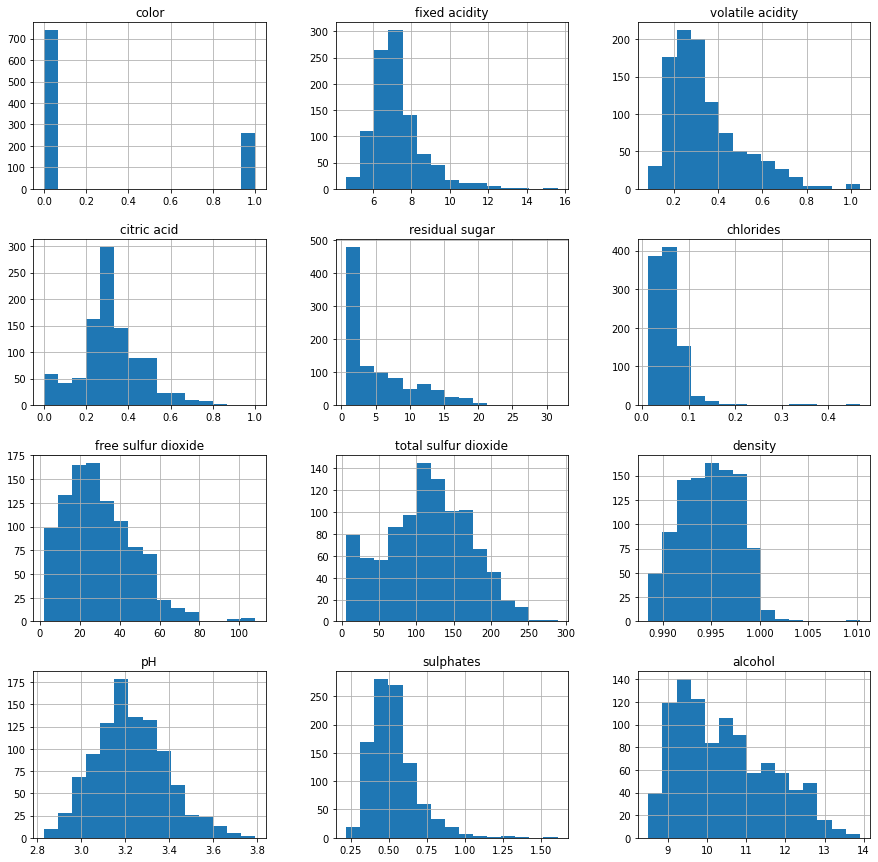

In [20]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

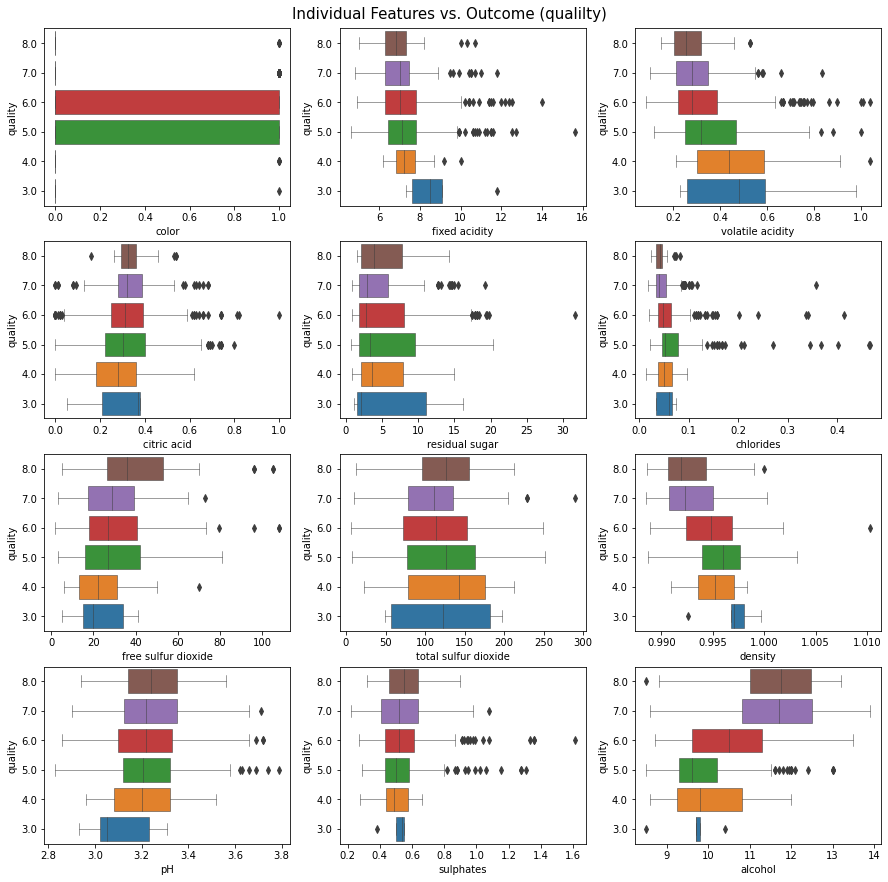

In [21]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x=x, y=y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

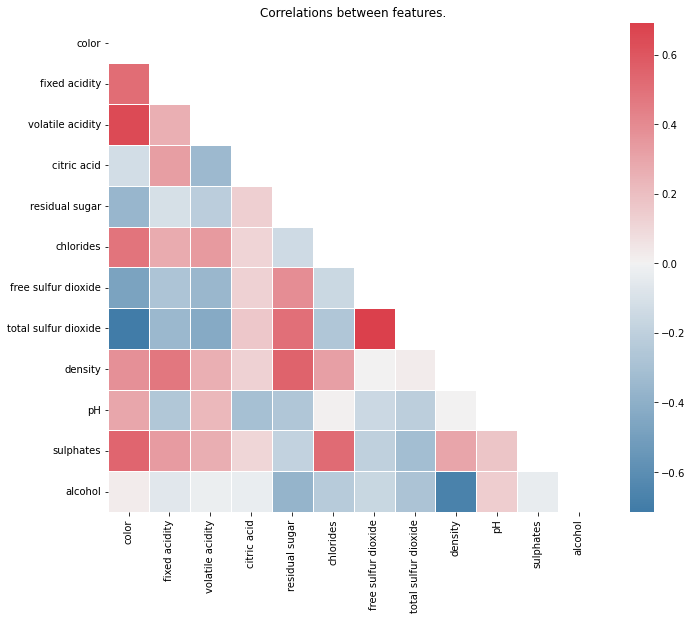

In [22]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

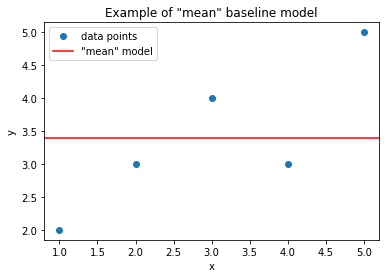

In [23]:
# points from our mini example from the demo 6 notebook
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### Q3 Tasks:
* __a) code + numeric answer on Canvas:__ Fill in the code below to compute the mean of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]

* __b) code + numeric answer on Canvas:__ Fill in the code below to compute the variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]

* __c) Multiple Choice Answer on Canvas:__ Which is the correct formula and interpretation for the OLS loss function?

* __d) Multiple Choice Answer on Canvas:__ In the context of linear models & vector computations what does it mean to 'augment' a datapoint and why do we do this?

* __e) code:__ Fill in the missing code to complete the`OLSLoss` function. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __f) Multiple Choice Answer on Canvas:__ Is computing the loss "embarrassingly parallel"?

* __g) code + numeric answer on Canvas:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model.

* __h) Multiple Choice Answer on Canvas:__  Compare your results in part __g__ to the result you got in part __a__. What is the explanation?

### Q3 Student Answers:

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

> __f)__ Type your answer here!

> __h)__ Type your answer here!  


In [25]:
# part a - mean of the outcome variable 
meanQuality = np.array(trainRDDCached.map(lambda x: x[1]).mean())
print(f"Mean: {meanQuality}")

Mean: 5.811040339702759


In [26]:
# part b - variance of the outcome variable 
varQuality = np.array(trainRDDCached.map(lambda x: x[1]).variance())
print(f"Variance: {varQuality}")

Variance: 0.760086564865664


In [27]:
# part e - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    w_broadcast = sc.broadcast(W)
    loss = augmentedData.map(lambda x: (np.dot(x[0], w_broadcast.value) - x[1])**2).mean()
    ################## (END) YOUR CODE ##################
    return loss

In [30]:
# part g - define your baseline model here
BASELINE = np.append([meanQuality], np.zeros(len(trainRDDCached.take(1)[0][0])))

In [31]:
# part g - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656636


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if it's working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a1) Multiple Choice Answer on Canvas__: 

* __a2) essay question:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the input data weighted by the errors where the error is proportional to the error'_. Write the formula for the gradient and explain how it reflects this phrase, which part corresponds to the data and to the error.  

* __b) essay question:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?

* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  

* __d) Multiple Choice Answer on Canvas:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?

* __e1) code:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. 
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._

* __e2) Multiple Choice Answer on Canvas:__ Use these results to explain what the problem was in 'd'.

### Q4 Student Answers:
> __a1)__ Type your answer here!  

> __a2)__ Type your answer here!  

> __b)__ Type your answer here! 

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ Type your answer here!  

> __e1)__ _complete the coding portions of this question before answering e2_ 

> __e2)__ Type your answer here!


In [32]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    w_broadcast = sc.broadcast(W)
    grad = (augmentedData.map(lambda x: x[0] * np.dot(x[0], w_broadcast.value) - x[1])).mean()
    new_model = learningRate * (w_broadcast.value - grad) 
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [33]:
%%time
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
# print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
#     loss = OLSLoss(trainRDDCached, model)
#     print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

----------
STEP: 1
Model: [0.581, 0.437, -3.606, 0.383, 0.397, -2.568, 0.549, -17.164, -66.739, 0.003, -1.29, 0.273, -5.516]
----------
STEP: 2
Model: [836.301, 86.97, 5856.66, 257.542, 277.975, 5470.413, 43.409, 30923.295, 119456.283, 831.84, 2674.812, 427.828, 8642.775]
----------
STEP: 3
Model: [-1495558.643, -154388.937, -10480851.187, -459773.668, -496387.09, -9792618.029, -76544.966, -55354978.085, -213828848.416, -1487679.165, -4786197.832, -764561.608, -15467225.167]
----------
STEP: 4
Model: [2677076401.598, 276359052.119, 18760900101.069, 823003546.517, 888542503.595, 17528961712.134, 137017906.849, 99086413690.55, 382757426454.1, 2662971994.304, 8567376023.152, 1368579217.741, 27686594163.948]
----------
STEP: 5
Model: [-4792014228217.128, -494687601217.05, -33582343846557.414, -1473190940026.966, -1590506836207.331, -31377152318236.062, -245264481682.148, -177366437938369.97, -685142580858887.9, -4766767089062.189, -15335754998783.664, -2449781066375.508, -49559494493965.49

In [36]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: (((x[0]-featureMeans) / featureStdev), x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [37]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [38]:
%%time
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 33.75522343360385
Model: [0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581, 0.581]
----------
STEP: 2
Loss: 32.54029394920183
Model: [0.581, 0.517, 0.521, 0.545, 0.576, 0.581, 0.512, 0.612, 0.643, 0.478, 0.598, 0.504, 0.685]
----------
STEP: 3
Loss: 32.791416274400575
Model: [0.581, 0.539, 0.538, 0.561, 0.576, 0.58, 0.53, 0.601, 0.632, 0.496, 0.602, 0.518, 0.677]
----------
STEP: 4
Loss: 32.73437420994888
Model: [0.581, 0.534, 0.534, 0.556, 0.577, 0.582, 0.526, 0.604, 0.636, 0.492, 0.601, 0.514, 0.679]
----------
STEP: 5
Loss: 32.74826945440187
Model: [0.581, 0.535, 0.535, 0.558, 0.576, 0.581, 0.527, 0.603, 0.635, 0.493, 0.601, 0.515, 0.678]
CPU times: user 97.1 ms, sys: 33.8 ms, total: 131 ms
Wall time: 1.84 s


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:

* __a) Multiple Choice Answer on Canvas:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 

* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.

* __c) Multiple Choice Answer on Canvas:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.

* __d) essay:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ Type your answer here!  

> __c)__ Type your answer here! 

> __d)__ Type your answer here!

In [ ]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = None
        training_loss = None
        test_loss = None
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [ ]:
# part c - plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    display(plt.show())

In [ ]:
# part c - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

In [ ]:
# part c - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression')

In [ ]:
# part c - save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

In [ ]:
# part d - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

In [ ]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression')

In [ ]:
# part d - run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

In [ ]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, it's just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place with no shuffle needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), sometimes called rotation estimation, or out-of-sample testing, is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross-validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/CV-ISLRp181.png?raw=true">


### Q6 Tasks:
* __a) Numerical answer:__ A naive approach to training an OLS Regression model with cross-validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) Multiple Dropdowns on Canvas:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records?

* __c) Short answer:__ How will these keys help us compute cross validated loss?

* __d) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross-validated error for a given set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __e) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __f) Multiple Choice on Canvas:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph?

### Q6 Student Answers:
> __a)__ Type your answer here!  

> __b)__ Type your answer here! 

> __c)__ Type your answer here!

> __f)__ Type your answer here!

In [ ]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [ ]:
# part d - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = None
    
    
    
    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [ ]:
# part e - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [ ]:
# part e - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        pass
        ############# (END) YOUR CODE ###########
    return new_models

In [ ]:
# part f - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
           
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist


In [ ]:
# part f -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 50, verbose = False)

In [ ]:
# part f - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are \\(2^{p}\\) potential models that can be built from \\(p\\) features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calculation (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the \\(L2\\) norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, \\(\lambda\\). Using \\(\LaTeX\\) in your Notebook and the **Equation Editor in Canvas**, write the formula for the loss function for Ridge Regularization.

* __b) short response:__ Using \\(\LaTeX\\) in your Notebook and the **Equation Editor in Canvas**, write the formula for the gradient for Ridge Regularization.

* __c) short response:__ The regularization term for lasso regression is the \\(L1\\) norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, \\(\lambda\\). Using \\(\LaTeX\\) in your Notebook and the **Equation Editor in Canvas**, write the formula for the loss function for Lasso Regularization.

* __d) short response:__ Using \\(\LaTeX\\) in your Notebook and the **Equation Editor in Canvas**, write the formula for the gradient for Lasso Regularization.

* __e) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using \\(L2\\) regularization if the parameter `regType` is set to `ridge`, \\(L1\\) regularization if set to `lasso` and unregularized OLS otherwise.

* __f) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!

> __f)__ Type your answer here!

In [ ]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################

    
    
    
    
    ################## (END) YOUR CODE ####################
    return new_model

In [ ]:
import numpy as np
W=np.array([1,-2,0,4])
print(2*np.append([0.0], W[1:]))
print(W)

wreg=np.sign(W)
wreg[0]=0
print(wreg)
print(W)

wReg = W * 1
wReg[-1] = 0
wReg=(wReg>0).astype(int) * 2-1
print(wReg)

In [ ]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [ ]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")

In [ ]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [ ]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")

In [ ]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then create a new RDD called `validationRDD` and compute the mean squared error on the new validation dataset for each of the three models. [__`TIP:`__ _the held out data is in its raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) numeric answer on Canvas:__ Enter the Mean Squared Error for the OLS model.

* __c) numeric answer on Canvas:__ Enter the Mean Squared Error for the Ridge model.

* __d) numeric answer on Canvas:__ Enter the Mean Squared Error for the Lasso model.

* __e) Multiple Choice Answer on Canvas:__ Which model performed best and what is a valid possible interpretation of these results?

* __f) Multiple Choice Answer on Canvas:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]

* __g) Multiple Choice Answer on Canvas:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process?

### Q8 Student Answers:

> __e)__ Type your answer here!  

> __f)__ Type your answer here!  

> __g)__ Type your answer here!  


In [ ]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [ ]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
validationRDD = None
############### YOUR CODE HERE #################






############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

In [ ]:
# part f - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [ ]:
# part f - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

In [ ]:
# part f - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x=x, y=y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
display(plt.show())

In [ ]:
# part g - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    display(plt.show())

In [ ]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

In [ ]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

In [ ]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform